In [1]:
from collections import namedtuple
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from pathlib import Path
from functools import partial
import itertools
from itertools import combinations
import re
import requests
import json
import scipy as sp
import scipy.stats
import sklearn
import sys
import time
import pyext.src.pynet_rng as rng
from src.wishart_synthetic_benchmark import (
example)
import pyext.src.matrix as mat
import pyext.src.stats as stats

In [2]:
key = jax.random.PRNGKey(13)
n = 4
shape = 1
dim = 4
df = 2
p = 4


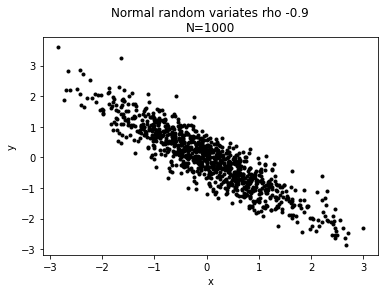

In [3]:
# Image Generating Values From a 2-d Gaussian

xy = -0.9
xx = 1.
yy = 1.
cov = jnp.array([[xx, xy],
                 [xy, yy]])
N=1000

mean = jnp.zeros(2)
data = jax.random.multivariate_normal(key, mean, cov, shape=(N,))



In [4]:
x_stats = stats.get_stats(data[:, 0])
y_stats = stats.get_stats(data[:, 1])

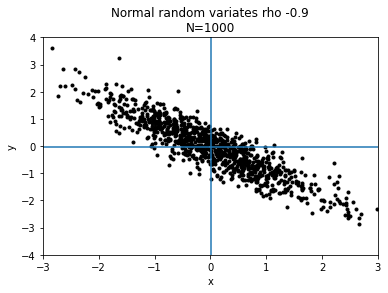

In [51]:
def scatter_plot(x, y, title=None, N=1000):
    assert len(x) == len(y)
    N = len(x)
    fig, axs = plt.subplots()
    if not title:
        title = f"Normal random variates rho {xy}\nN={N}"
    plt.plot(x, y, 'k.')
    plt.title(f"Normal random variates rho {xy}\nN={N}")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim((-4, 4))
    plt.xlim((-3, 3))
    ax = fig.gca()
    ax.vlines(np.mean(x), ymin=-5, ymax=5)
    ax.hlines(np.mean(y), xmin=-3, xmax=3)
scatter_plot(data[:, 0], data[:, 1])

/home/aji/anaconda3/envs/pynetp3.10.0/lib/python3.10/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


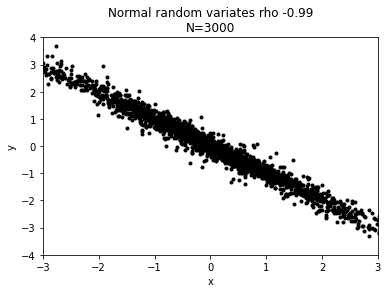

In [88]:
scale = 1.
xy = -0.99
cov_prior = jnp.array([[scale, xy],
                       [xy, scale]])

assert mat.is_positive_definite(cov_prior)

def rprior(key, n=2, p=2):
    return rng.wishart(key, V=cov_prior, n=n, p=p)

def rprior_pred(key, N=3):
    keys = jax.random.split(key, 2)
    S = rprior(keys[0])
    return jax.random.multivariate_normal(keys[1], mean, cov=S, shape=(N,))

def get_prior_pred(key, N=3, n_samples=100, n=2, p=2):
    Val = namedtuple("Val", "key data")
    data = jnp.zeros((n_samples, N, p))
    
    def body(i, val):
        # N x p
        key, k1 = jax.random.split(val.key)
        prior_pred = rprior_pred(k1, N)
        data = val.data.at[i].set(prior_pred)
        return Val(key, data)
    
    init = Val(key, data)
    val = jax.lax.fori_loop(0, n_samples, body, init)
    return val

    

n_samples = 1000
val = jax.jit(partial(get_prior_pred, n_samples=n_samples))(key)

x = np.ravel(val.data[:, :, 0])
y = np.ravel(val.data[:, :, 1])
scatter_plot(x, y, )

In [75]:
# Get the stats
ss = []
for i in range(n_samples):
    d = val.data[i]
    sx = stats.get_stats(d[:, 0])
    sy = stats.get_stats(d[:, 1])
    ss.apend(s)
    

TypeError: get_stats() takes 1 positional argument but 2 were given

In [49]:
val.data.shape

(100, 3, 2)